# Deep Learning on Inner speech

In [1]:
#@title Install dependencies 
!git clone https://github.com/N-Nieto/Inner_Speech_Dataset -q
!pip3 install mne -q
!pip install umap-learn

!pip3 install pyriemann
from sklearn.cluster import KMeans
from pyriemann.estimation import Covariances
from pyriemann.utils.base import invsqrtm
!pip3 install torchinfo

fatal: destination path 'Inner_Speech_Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Imports 
import os
import mne 
import time
import copy
import pickle
import random
import torch
import warnings
import torchvision
import gc
import collections
import umap


import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from google.colab import drive, files
from tqdm.notebook import tqdm, trange
from torch.utils.data import random_split
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject, Extract_block_data_from_subject, Extract_data_multisubject
from Inner_Speech_Dataset.Python_Processing.Data_processing import *

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

In [3]:
#@title Set random seed
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)
SEED = 23
set_seed(seed=SEED)

Random seed 23 has been set.


In [4]:
# @title Set device (GPU or CPU).

# inform the user if the notebook uses GPU or CPU.
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("No GPU enabled in this notebook.")
  else:
    print("GPU is enabled in this notebook.")

  return device


DEVICE = set_device()

GPU is enabled in this notebook.


# Data Loading

In [5]:
# @title función buscar path, sino crearlo {form-width:"25%"}

def ensure_dir(dir_name):
  import os
  if not os.path.exists(dir_name):
      os.makedirs(dir_name)

In [6]:
# @title Mount drive {form-width:"25%"}
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Implementación de métodos

In [7]:
#@title extract_data_ms { form-width: "25%" }

def Extract_data_multisubject_label(root_dir, N_S_list, datatype='EEG'):
    """
    Load all blocks for a list of subject and stack the results in X
    """
    print("Ejecutando Extract_data_multisubject_label")

    N_B_arr = [1, 2, 3]
    tmp_list_X = []
    tmp_list_Y = []
    rows = []
    total_elem = len(N_S_list)*3  # assume 3 sessions per subject
    S = 0
    for N_S in N_S_list:
        print("Iteration ", S)
        print("Subject ", N_S)
        for N_B in N_B_arr:

            # name correction if N_Subj is less than 10
            if N_S < 10:
                Num_s = 'sub-0'+str(N_S)
            else:
                Num_s = 'sub-'+str(N_S)

            base_file_name = root_dir + '/derivatives/' + Num_s + \
                '/ses-0' + str(N_B) + '/' + Num_s+'_ses-0'+str(N_B)
            events_file_name = base_file_name+'_events.dat'

            if datatype == "EEG" or datatype == "eeg":
                #  load data and events
                eeg_file_name = base_file_name+'_eeg-epo.fif'
                print("Inner iteration ", N_B)
                data_tmp_X = mne.read_epochs(
                    eeg_file_name, verbose='WARNING')._data
                rows.append(data_tmp_X.shape[0])
                if S == 0 and N_B == 1:  # assume same number of channels, time steps, and column labels in every subject and session
                    print("saving channels and steps")
                    chann = data_tmp_X.shape[1]
                    steps = data_tmp_X.shape[2]
                    # columns=data_tmp_Y.shape[1]
                tmp_list_X.append(data_tmp_X)
                tmp_list_Y.append(np.ones(data_tmp_X.shape[0])*S)

            # ToDo improvement not applied to exg and baseline datatypes yet
            elif datatype == "EXG" or datatype == "exg":
                file_name = root_dir + '/derivatives/' + Num_s + '/ses-0' + \
                    str(N_B) + '/' + Num_s+'_ses-0'+str(N_B)+'_exg-epo.fif'
                X = mne.read_epochs(file_name, verbose='WARNING')
                data[N_B] = X._data

            elif datatype == "Baseline" or datatype == "baseline":
                file_name = root_dir + '/derivatives/' + Num_s + '/ses-0' + \
                    str(N_B) + '/' + Num_s+'_ses-0' + \
                    str(N_B)+'_baseline-epo.fif'
                X = mne.read_epochs(file_name, verbose='WARNING')
                data[N_B] = X._data

            else:
                print("Invalid Datatype")
        S += 1

    X = np.empty((sum(rows), chann, steps))
    Y = np.empty((sum(rows)), dtype=np.int8)
    offset = 0
    # put elements of list into numpy array
    for i in range(total_elem):
        print("Saving element into array: ", i)
        X[offset:offset+rows[i], :, :] = tmp_list_X[0]
        Y[offset:offset+rows[i]] = tmp_list_Y[0]
        offset += rows[i]
        del tmp_list_X[0]
        del tmp_list_Y[0]
        gc.collect()
    print("X shape", X.shape)
    print("Y shape", Y.shape)
    return X, Y


def extract_data_ms(root_dir, datatype, subjects=None, real_task=True):
    """Dependiendo si se quiere pre entrenar un modelo con dummy task o real task,
    se ejecutará el Extract_data implementado en github o el implementado localmente, el 
    cual reacomoda los labels

    Args:
        root_dir (_type_): path de archivos
        datatype (_type_): tipo de archivo
        real_task (bool, optional): real task o dummy task. Defaults to True.
        subjects (list[integer], optional): lista de sujetos. Defaults to None.

    Returns:
        X_raw (numpy array): Trials por sujeto
        Y (numpy array): Labels
    """
    print("Ejecutando extract_data_ms")
  # a subject is kept away for fine tuning
    if (subjects == None):
        L = [i+1 for i in range(10)]
        L.pop(sub-1)

        # # delete "bad" subjects from pre training
        # L.pop(2-1)
        # L.pop(4-1-1)
        # L.pop(8-1-1-1)
    else:
        L = [subjects]
    print(L)

    # real task
    if(real_task):
        X_raw, Y = Extract_data_multisubject(root_dir, L, datatype=datatype)
    else:
        # dummy task
        X_raw, Y = Extract_data_multisubject_label(
            root_dir, L, datatype=datatype)

    print("\n \n")
    print(X_raw.shape)
    print(Y.shape)
    print(Y.dtype)

    return X_raw, Y


In [8]:
# @title select_time_window {form-width: "25%"}
def cut_useful_time(X_raw, t_start=1.5, t_end=3.5, fs=256, float_point=None):
    print("Ejecutando cut_useful_time")
    """Se recortan los datos en la ventana de tiempo con mayor actividad (tiempo útil)

    Args:
        X_raw (_type_): Datos en crudo, retornados del extract multi subject
        t_start (float, optional): inicio de ventana de tiempo. Defaults to 1.5.
        t_end (float, optional): finalización de ventana de tiempo. Defaults to 3.5.
        fs (int, optional): frecuencia de muestreo. Defaults to 256.
        float_point (_type_, optional): bits para punto flotante. Defaults to None = 64bits.

    Returns:
        _type_: _description_
    """
    # Cut useful time
    import gc
    X = Select_time_window(X=X_raw, t_start=t_start, t_end=t_end, fs=fs)
    print(X.shape)
    del X_raw
    gc.collect()

    X = cast_float_point(X, float_point)

    return X


def cast_float_point(X, float_point=None):
    """casteo de np array a los bits seleccionados

    Args:
        X (_type_): Ventana del tiempo útil de los datos. Datos retornado de Select_time_window
        float_point (_type_, optional): bits para punto flotante. Defaults to None = 64bits.

    Returns:
        _type_: numpy array
    """
    if float_point == 32:
        X = np.float32(X)
    elif float_point == 16:
        X = np.float16(X)

    return X


In [9]:
# @title data_processing {form-width: "25%"}
def transform_for_classificator(X, Y, Classes, Conditions, real_task=True):
    print("Ejecutando transform_for_classificator")
    if(real_task):
        # for pre train with real task
        X, Y = Transform_for_classificator(X, Y, Classes, Conditions)
    else:
        # for pre train with dummy task
        X, Y = Transform_for_classificator_label(X, Y, Classes, Conditions)

    return X, Y


def split_data(X, Y, test_size, val_size, scl, SEED, window_len, window_step, fs=256, pre_train=False):
    print("Ejecutando split_data")
    if(pre_train):
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, Y, test_size=val_size, random_state=SEED, stratify=Y)
        # Split Trial
        del X, Y
        import gc
        gc.collect()
        X_train, Y_train = Split_trial_in_time(
            X_train, Y_train, window_len, window_step, fs)
        X_val, Y_val = Split_trial_in_time(
            X_val, Y_val, window_len, window_step, fs)
        X_test = None
        Y_test = None
        len_window_sample = None
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=SEED, stratify=Y)
        X_train, X_val, Y_train, Y_val = train_test_split(
            X_train, Y_train, test_size=val_size, random_state=SEED, stratify=Y_train)
        X_in_shape = X_train.shape[0]

        X_train, Y_train = Split_trial_in_time(
            X_train, Y_train, window_len, window_step, fs)
        X_val, Y_val = Split_trial_in_time(
            X_val, Y_val, window_len, window_step, fs)
        X_test, Y_test = Split_trial_in_time(
            X_test, Y_test, window_len, window_step, fs)
        X_out_shape = X_train.shape[0]
        len_window_sample = int(X_out_shape/X_in_shape)

    # Scale to [0,1] each channel
    for chn in range(X_train.shape[1]):
        X_train[:, chn, :] = scl.fit_transform(X_train[:, chn, :])

        X_val[:, chn, :] = scl.transform(X_val[:, chn, :])
        if(not pre_train):
            X_test[:, chn, :] = scl.transform(X_test[:, chn, :])

    # print("Final data shape")
    # print("X_train.shape", X_train.shape)
    # print("X_val.shape", X_val.shape)
    # print("X_test.shape", X_test.shape)

    # print("Data atributes")
    # print("Min:" + str(X_train.min()))
    # print("Max:" + str(X_train.max()))
    # print("Data Type:" + str(X_train.dtype))

    # print("saving Y files in pretraining")
    # with open('/gdrive/My Drive/DataSet/luchi/Ytr.npy', 'wb+') as f:
    #   print(f"about to save Ytr, size {Y_train.shape}")
    #   np.save(f, Y_train)
    # with open('/gdrive/My Drive/DataSet/luchi/Yval.npy', 'wb+') as f:
    #   print(f"about to save Ytr, size {Y_val.shape}")
    #   np.save(f, Y_val)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, len_window_sample


In [10]:
# @title euclidean_aligment {form-width:"25%"}



def EU(Xtr, Xval, Xte=None):
    print("Ejecutando EU")
    """Euclidean Aligment

    Args:
        Xtr (_type_): los sujetos del pretrn
        Xval (_type_): el sujeto a finetunear
        Xte (_type_, optional): el sujeto a finetunear. Defaults to None.

    Returns:
        _type_: 
        Xtr_eu -> los datos de los sujetos utilizados en pre-train, alineados (para luego subdividir en train y validacion)
        Xval_eu -> los datos del sujeto utilizado en fine tuning, alineados, para subdividir en train y validacion del fine tuning
        Xte_eu -> los datos del sujeto utilizado en fine tuning, alineados, para test
    """

    # Estimate single trial covariance
    cov_tr = Covariances().transform(Xtr)
    # cov_tr_fine= Covariances().transform(Xtr_fine)

    Ctr = cov_tr.mean(0)
    # Ctr_fine = cov_tr_fine.mean(0)

    # aligment
    Xtr_eu = np.asarray([np.dot(invsqrtm(Ctr), epoch) for epoch in Xtr])
    Xval_eu = np.asarray([np.dot(invsqrtm(Ctr), epoch) for epoch in Xval])
    if (Xte is not None):
        Xte_eu = np.asarray([np.dot(invsqrtm(Ctr), epoch) for epoch in Xte])
    else:
        Xte_eu = None
        # print("saving EU files in pretraining")
        # with open('/gdrive/My Drive/DataSet/luchi/Xtr.npy', 'wb+') as f:
        #   print(f"about to save Xtr eu, size {Xtr_eu.shape}")
        #   np.save(f, Xtr_eu)
        # with open('/gdrive/My Drive/DataSet/luchi/Xval.npy', 'wb+') as f:
        #   print(f"about to save Xtr eu, size {Xval_eu.shape}")
        #   np.save(f, Xval_eu)

    return Xtr_eu, Xval_eu, Xte_eu


In [11]:
# @title cast_to_dataset {form-width:"25%"}

def convert_to_dataset(X_numpy, Y_numpy, DEVICE):
  print("Ejecutando convert_to_dataset")
  # Convert data from numpy to Tensor
  tensor_X = torch.Tensor(X_numpy).to(DEVICE)
  import gc
  del X_numpy
  gc.collect()
  # Add the "channel" dimension for CNNs
  tensor_X = torch.unsqueeze(tensor_X,1).to(DEVICE)

  # convert labels to tensor
  tensor_Y = torch.Tensor(Y_numpy).to(DEVICE)
  import gc
  del Y_numpy
  gc.collect()
  tensor_Y = tensor_Y.type(torch.LongTensor)

  # Create a Pytorch Dataset
  print(tensor_X.shape)
  print(tensor_Y.shape)
  Dataset_tensor = torch.utils.data.TensorDataset(tensor_X,tensor_Y)
  import gc
  del tensor_X, tensor_Y
  gc.collect()
  return Dataset_tensor



In [12]:
# @title Inet {form-width:"25%"}

class INet(nn.Module):
    def __init__(self, n_classes):
        super(INet, self).__init__()

        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.2)
        self.drop3 = nn.Dropout(p=0.3)
#(1280x256 and 1536x8)
        self.fc1 = nn.Linear(256, 8)  # for 0.2 len
        self.fc2 = nn.Linear(8, n_classes)

        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)

    def forward(self, x):

        x = self.conv1(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.drop2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.elu(x)

        x = self.fc2(x)

        return x


In [13]:
# @title modelo {form-width: "25%"}
from torchinfo import summary
def init_net(Y, pre_train, save_dir, DEVICE):
    print("Ejecutando init_net")
    n_classes = len(np.unique(Y))
    print("Total classes: ", n_classes)
    in_net = INet(n_classes=n_classes).to(DEVICE)
    print("Total Parameters in Network {:10d}".format(
        sum(p.numel() for p in in_net.parameters())))
    # uncomment line below to get model summary
    # print(summary(in_net, (128, 1, 128, 51)))

    if pre_train:
        print(f"loading model from {save_dir}/best_model.pt")
        in_net.load_state_dict(torch.load(save_dir+'/best_model.pt'))
        in_net.fc2 = nn.Linear(8, n_classes).to(
            DEVICE)  # fine tune the last linear layer
    return in_net

In [14]:
# @title test_model {form-width: "25%"}

def Most_Common(lst):
    # https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
    import collections
    # print(lst)
    data = collections.Counter(lst)
    return data.most_common(1)[0][0], data


def test_model(best_model, test_loader, DEVICE, len_window_sample):
    print("Ejecutando test_model")
    # Total data
    total_vot = 0
    total = 0
    # Correct data
    correct_vot = 0
    correct = 0

    #p = 0
    predicted_err = []  # Y PREDICHO
    target_err = []  # Y TEST

    for data, target in test_loader:
        # Get data in Device
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Predict with the best model the data
        output = best_model(data)

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        acc = correct/total

        # get accuracy (votacion)
        steps = int(output.shape[0]/len_window_sample)
        print("steps", steps)
        for i in range(0, steps):
            _, predicted_vot = torch.max(
                output[len_window_sample*i:len_window_sample*(i+1), :], 1)

            predicted_vot, data_x = Most_Common(predicted_vot)
            target_a, data_y = Most_Common(
                target[len_window_sample*i:len_window_sample*(i+1)])

            # comparar cuantos le pega por trial
            aux_x = sorted(data_x.elements())
            aux_y = sorted(data_y.elements())
            # Si predicho y real difieren, los guardo para sacar estadisticos
            if(aux_x != aux_y):
                predicted_err.append(aux_x)
                target_err.append(aux_y)

            #p += 1
            total_vot += 1
            correct_vot += (predicted_vot == target_a).sum().item()

    acc_vot = correct_vot/total_vot
    print("Final Test Acc")
    print(acc_vot)
    print("trials dif", len(predicted_err))
    #accuracy normal, acc con votacion, trials en los que no se acerto en al menos una ventana
    return acc, acc_vot, predicted_err, target_err


In [15]:
# @title train_loop {form-width: "25%"}

# v5, use early stopping for both pre training and fine tuning, pre training with real task
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer, epochs_er_stop, min_epochs, plotting=True, plot_type="loss"):
    print("Ejecutando train")
    from IPython import display
    validation_acc_ref = 0
    loss_ref = 3
    tol = 0.001
    count = 0
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    # to run GUI event loop
    plt.ion()
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            print(epoch)
            model.train()

            # keeps track of the running loss
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # 1. Get the model output (call the model with the data from this batch)
                output = model(data)

                # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
                #                       has collected so far with optimizer.zero_grad())
                optimizer.zero_grad()

                # 3. Get the Loss (call the loss criterion with the model's output
                #                  and the target values)
                loss = criterion(output, target)

                # 4. Calculate the gradients (do the pass backwards from the loss
                #                             with loss.backward())
                loss.backward()

                # 5. Update the weights (using the training step of the optimizer,
                #                        optimizer.step())
                optimizer.step()

                # set loss to whatever you end up naming your variable when
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            print("epoch {} running loss {}".format(
                epoch, running_loss/len(validation_loader)))
            print("loss ref ", loss_ref)
            # Early stoping
            if running_loss/len(validation_loader) > loss_ref - tol:
                print("detected condition for early stopping")
                count += 1
                # Number of epochs with not improving loss
                print("count is {}".format(count))
                if count == epochs_er_stop:
                    if epoch > min_epochs:
                        print("breaking training loop")
                        count = 0
                        break
                    else:
                        print("reached early stopping condition, but no more than {} epochs have passed".format(
                            min_epochs))
            else:
                print("loss was better than before, count 0")
                # Restart count
                # Update the reference loss
                loss_ref = running_loss/len(validation_loader)
                print("loss ref is now {}".format(loss_ref))
                count = 0

            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
            print("val accuracy for this batch is ", correct/total)
            # loss_ref=running_loss/len(validation_loader)
            if correct/total > validation_acc_ref:
                print("Save best model in epoche" + str(epoch) +
                      "with validation ACC : " + str(correct/total))
                best_model = copy.deepcopy(model)
                best_epoch = epoch
                validation_acc_ref = correct/total

            # Loss eval
            if plotting:
                print("im plotting")
                plt.title('Train vs Valid Loss')
                plt.ylabel('Loss')
                plt.legend(['Train', 'Valid'])
                plt.xlabel('epoch')
                # plt.clf()
                if plot_type == "loss":
                    plt.title('Train vs Valid Loss')
                    plt.ylabel('Loss')
                    plt.legend(['Train', 'Valid'])
                    plt.xlabel('epoch')
                    plt.plot(train_loss)
                    plt.plot(validation_loss)
                    # to refresh same plot on every loop
                    # time.sleep(1)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    plt.show()

                # plt.show()
                # flag = 0

    return train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch


In [16]:
# @title trainer {form-width:"25%"}

def trainer(in_net, train_loader, val_loader, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting, pre_train):
    print("Ejecutando trainer")
    # Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, in_net.parameters()), lr=lr)

    # Loss
    criterion = nn.CrossEntropyLoss().to(DEVICE)

    # Train model
    train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = train(in_net, DEVICE, train_loader, val_loader,
                                                                                           epochs, criterion, optimizer, epochs_er_stop=epochs_er_stop,
                                                                                           min_epochs=min_epochs, plotting=plotting)

    if(pre_train):
      save_dir = save_dir+'/pre_train/subj-'+str(sub)
      ensure_dir(save_dir+'/best_model.pt')
      print(f"saved best best model in {save_dir}/best_model.pt")
      torch.save(best_model.state_dict(), save_dir+'/best_model.pt')
      print("saved best model in epoch ", best_epoch)

    return train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch


def trainer_kfold(X, Y, eu_aligment, k_fold, batch_size, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting):
    print("Ejecutando trainer_kfold")
    accs_vote = []
    accs_normal = []
  
    save_loss_dir = save_dir+'/results/loss'
    ensure_dir(save_loss_dir)
    save_acc_dir = save_dir+'/results/acc'
    ensure_dir(save_acc_dir)

    for i in range(k_fold):
        ################################
        # split para fine-tuning
        X_train, X_val, X_test, Y_train, Y_val, Y_test, len_window_sample = split_data(
            X, Y, test_size=test_len, val_size=val_len, scl=scl, SEED=i, window_len=window_len, window_step=window_step, fs=fs, pre_train=False)

        ################################
        # alineamiento euclideo para fine-tuning
        if(eu_aligment):
            X_train, X_val, X_test = EU(Xtr=X_train, Xval=X_val, Xte=X_test)

        Dataset_tensor_train = convert_to_dataset(X_train, Y_train, DEVICE)
        Dataset_tensor_val = convert_to_dataset(X_val, Y_val, DEVICE)
        Dataset_tensor_test = convert_to_dataset(X_test, Y_test, DEVICE)

        #Dataloaders
        train_loader = torch.utils.data.DataLoader(
            Dataset_tensor_train, batch_size=batch_size, shuffle=True)  # probar con shuffle en true
        val_loader = torch.utils.data.DataLoader(
            Dataset_tensor_val, batch_size=batch_size, shuffle=True)  # probar con shuffle en true
        test_loader = torch.utils.data.DataLoader(Dataset_tensor_test, batch_size=int(
            len_window_sample*batch_size), shuffle=False)
        
        # Definición de parámetros
        in_net = init_net(Y_train, pre_train, save_dir, DEVICE)

        train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = trainer(
            in_net, train_loader, val_loader, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting=plotting, pre_train=False)

        print("saved best model in epoch ", best_epoch)
        # Plot final results
        plt.figure()
        plt.plot(train_loss)
        plt.plot(validation_loss)
        plt.title("Train and validation loss for fold " + str(i))
        plt.grid()
        
        plt.savefig(save_loss_dir+'/fold_'+str(i)+'-loss.png')
        
        # Plot final results
        plt.figure()
        plt.plot(train_acc)
        plt.plot(validation_acc)
        plt.title("Train and validation accuracy for fold " + str(i))
        plt.grid()
        
        plt.savefig(save_acc_dir+'/fold_'+str(i)+'-acc.png')

        acc_normal, acc_vote, predicted_err, target_err = test_model(
            best_model, test_loader, DEVICE, len_window_sample)
        accs_vote.append(acc_vote)
        accs_normal.append(acc_normal)
        with open(save_acc_dir+'/accs-sub'+str(sub)+'.txt', 'w') as filehandle:
            filehandle.writelines("%s\n" % a for a in accs_vote)

    # print(accs)
    return accs_vote, accs_normal


In [17]:
# @title wrapper pre-train {form-width:"25%"}
def wrapper_pre_train(root_dir, save_dir, datatype, t_start, t_end, fs, float_point, Classes, Conditions, batch_size_pre, val_len, window_len, window_step, scl, SEED, eu_aligment, DEVICE, sub, plotting):
  print("Ejecutando PRE-TRAINING")
  X_raw, Y = extract_data_ms(root_dir, datatype)

  import gc
  #################################
  # Selección de tiempo útil
  X = cut_useful_time(X_raw, t_start=t_start, t_end=t_end,
                      fs=fs, float_point=float_point)
  del X_raw
  gc.collect()
  ################################
  # data processing
  # transform for classificator para pre-train
  X, Y = transform_for_classificator(X, Y, Classes, Conditions)

  ################################
  # split para pre train
  X_train, X_val, _, Y_train, Y_val, _, _ = split_data(
      X, Y, test_size=None, val_size=val_len, scl=scl, SEED=SEED, window_len=window_len, window_step=window_step, fs=fs, pre_train=True)
  del X, Y
  gc.collect()

  #################################
  # Alineamiento euclideo para pre-train
  if (eu_aligment):
      X_train, X_val, _ = EU(Xtr=X_train, Xval=X_val, Xte=None)

  # with open('/gdrive/My Drive/DataSet/luchi/Xtr.npy', 'rb') as f:
  #   X_train = np.load(f)

  # with open('/gdrive/My Drive/DataSet/luchi/Xval.npy', 'rb') as f:
  #   X_val = np.load(f)

  # with open('/gdrive/My Drive/DataSet/luchi/Ytr.npy', 'rb') as f:
  #   Y_train = np.load(f)

  # with open('/gdrive/My Drive/DataSet/luchi/Yval.npy', 'rb') as f:
  #   Y_val = np.load(f)

  #################################
  print(X_train.shape)
  print(X_val.shape)
  print(Y_train.shape)
  print(Y_val.shape)
  # castear a dataset
  dataset_tensor_train = convert_to_dataset(X_train, Y_train, DEVICE)
  dataset_tensor_val = convert_to_dataset(X_val, Y_val, DEVICE)

  train_loader_pre = torch.utils.data.DataLoader(
      dataset_tensor_train, batch_size=batch_size_pre, shuffle=True)
  val_loader_pre = torch.utils.data.DataLoader(
      dataset_tensor_val, batch_size=batch_size_pre, shuffle=False)


  ###############################
  #   ENTRENAMIENTO PRE TRAIN   #
  ###############################

  # definicion de parametros
  in_net = init_net(Y_train, False, save_dir, DEVICE)
  lr = 0.001
  epochs = 10
  min_epochs = 40
  epochs_er_stop = 20

  train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = trainer(
      in_net, train_loader_pre, val_loader_pre, lr, epochs, min_epochs, epochs_er_stop, DEVICE, root_dir, sub, plotting, pre_train)
  plt.plot(train_acc)
  plt.plot(validation_acc)

In [18]:
# @title wrapper_fine_tuning {form-width:"25%"}

def wrapper_fine_tuning(root_dir, model_name, datatype, sub, t_start, t_end, fs, float_point, Classes, Conditions, test_len, val_len, window_len, window_step, scl, SEED, eu_aligment, DEVICE, plotting):
    # Carga de los datos para los sujetos seleccionados, en el caso del fine tuning será uno solo
    X_raw_fine, Y_fine = extract_data_ms(root_dir, datatype, subjects=sub)
    # print(X_raw_fine.shape)
    # print(Y_fine.shape)
    # print(Y_fine.dtype)

    #################################
    # Seleccion de tiempo útil
    X_fine = cut_useful_time(X_raw_fine, t_start=t_start,
                             t_end=t_end, fs=fs, float_point=float_point)

    ################################
    # data processing
    # transform for classificator para fine-tuning
    X, Y = transform_for_classificator(X_fine, Y_fine, Classes, Conditions)

    ##############################
    # ENTRENAMIENTO FINE-TUNING  #
    #############################

    # Learning rate
    lr = 0.001
    epochs = 10
    min_epochs = 40
    # Max Epoches

    # Epoches for Early stopping
    epochs_er_stop = 100
    # # Create a Pytorch Dataset
    batch_size = 128

    k_fold = 20

    # K-fold
    accs_normal, accs_vote = trainer_kfold(X, Y, eu_aligment, k_fold, batch_size, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting)


# Parámetros globales

In [19]:
# @title Parámetros globales {form-width:"25%"}

#plot epoca a epoca
plotting = False

# Path de archivos (Raiz)
root_dir = "/gdrive/My Drive/DataSet"

#Seleccionar tipo de entrenamiento
# True = pre train + fine tuning | False = entrenamiento simple
pre_train = True

# alineamiento euclideo
eu_aligment = True

#Armo el path dependiendo el entrenamiento
if(pre_train and eu_aligment):
  # tipo_entrenamiento = '/pre_train_EU_005/' # esto estaba mal
  tipo_entrenamiento = '/pre_train'
elif(eu_aligment):
  tipo_entrenamiento = '/simple_EU'
else:
  tipo_entrenamiento = '/simple'
# tipo_entrenamiento = '/pre_train/'


#Sujeto a testear
sub = 1
save_dir = root_dir + tipo_entrenamiento + '/subj-' + str(sub)
# path para guardar resultados
ensure_dir(save_dir)

datatype = "EEG"
# change float point of data for faster implementations, default: float64
float_point = 32

# Sampling rate
fs = 256

# Time window analysis
t_start = 1.5
t_end = 3.5
# Window's parameters to crop each trial
window_len = 0.05
window_step = 0.05

# Test Examples %
test_len = 0.2

# Examples within train set used as validation %
val_len = 0.2


# Parámetros pre-train
# Batch size
# batch_size = 32
batch_size_pre = 1280


# Compared conditions
Conditions = [["Inner"], ["Vis"]]

# Choos the classes to groop and comare
Classes = [["All"], ["All"]]

# Scaler
scl = MinMaxScaler()

# Se selecciona que tarea realizará el pre entrenamiento (igual no se usa)
# real_task = True -> tarea real
# real_task = False -> tarea dummy
real_task = True

# MAIN

pre train
Ejecutando PRE-TRAINING
Ejecutando extract_data_ms
[2, 3, 4, 5, 6, 7, 8, 9, 10]
Iteration  0
Subject  2
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  1
Subject  3
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  2
Subject  4
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  3
Subject  5
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  4
Subject  6
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  5
Subject  7
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  6
Subject  8
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  7
Subject  9
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  8
Subject  10
Inner iteration  1
Inner iteration  2
Inner iteration  3
Saving element 0 into array 
Saving element 1 into array 
Saving element 2 into array 
Saving element 3 into array 
Saving element 4 into array 
Saving element 5 into array 
Saving

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6952572258619162
loss ref  3
loss was better than before, count 0
loss ref is now 0.6952572258619162
val accuracy for this batch is  0.4945321992709599
Save best model in epoche0with validation ACC : 0.4945321992709599
1
epoch 1 running loss 0.6936926016440759
loss ref  0.6952572258619162
loss was better than before, count 0
loss ref is now 0.6936926016440759
val accuracy for this batch is  0.49456335483066954
Save best model in epoche1with validation ACC : 0.49456335483066954
2
epoch 2 running loss 0.6936108676286844
loss ref  0.6936926016440759
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4945321992709599
3
epoch 3 running loss 0.6933901607990265
loss ref  0.6936926016440759
detected condition for early stopping
count is 2
val accuracy for this batch is  0.49456335483066954
4
epoch 4 running loss 0.6930485597023597
loss ref  0.6936926016440759
detected condition for early stopping
count is 3
val accuracy for this batch is

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.697682449221611
loss ref  3
loss was better than before, count 0
loss ref is now 0.697682449221611
val accuracy for this batch is  0.4967948717948718
Save best model in epoche0with validation ACC : 0.4967948717948718
1
epoch 1 running loss 0.6941324770450592
loss ref  0.697682449221611
loss was better than before, count 0
loss ref is now 0.6941324770450592
val accuracy for this batch is  0.499599358974359
Save best model in epoche1with validation ACC : 0.499599358974359
2
epoch 2 running loss 0.6937833040952682
loss ref  0.6941324770450592
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5072115384615384
Save best model in epoche2with validation ACC : 0.5072115384615384
3
epoch 3 running loss 0.692105108499527
loss ref  0.6941324770450592
loss was better than before, count 0
loss ref is now 0.692105108499527
val accuracy for this batch is  0.5228365384615384
Save best model in epoche3with validation ACC : 0.5228365384615384
4
e

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6947138845920563
loss ref  3
loss was better than before, count 0
loss ref is now 0.6947138845920563
val accuracy for this batch is  0.49559294871794873
Save best model in epoche0with validation ACC : 0.49559294871794873
1
epoch 1 running loss 0.6980221778154373
loss ref  0.6947138845920563
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
Save best model in epoche1with validation ACC : 0.5
2
epoch 2 running loss 0.6945797502994537
loss ref  0.6947138845920563
detected condition for early stopping
count is 2
val accuracy for this batch is  0.499599358974359
3
epoch 3 running loss 0.6933191925287246
loss ref  0.6947138845920563
loss was better than before, count 0
loss ref is now 0.6933191925287246
val accuracy for this batch is  0.49439102564102566
4
epoch 4 running loss 0.6929117411375045
loss ref  0.6933191925287246
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5048076923076923
Save best 

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6928371727466583
loss ref  3
loss was better than before, count 0
loss ref is now 0.6928371727466583
val accuracy for this batch is  0.5040064102564102
Save best model in epoche0with validation ACC : 0.5040064102564102
1
epoch 1 running loss 0.6925249010324478
loss ref  0.6928371727466583
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5116185897435898
Save best model in epoche1with validation ACC : 0.5116185897435898
2
epoch 2 running loss 0.6920116186141968
loss ref  0.6928371727466583
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5124198717948718
Save best model in epoche2with validation ACC : 0.5124198717948718
3
epoch 3 running loss 0.6910482853651047
loss ref  0.6928371727466583
loss was better than before, count 0
loss ref is now 0.6910482853651047
val accuracy for this batch is  0.532051282051282
Save best model in epoche3with validation ACC : 0.532051282051282
4
epoch 4 running los

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6925638020038605
loss ref  3
loss was better than before, count 0
loss ref is now 0.6925638020038605
val accuracy for this batch is  0.5068108974358975
Save best model in epoche0with validation ACC : 0.5068108974358975
1
epoch 1 running loss 0.691105404496193
loss ref  0.6925638020038605
loss was better than before, count 0
loss ref is now 0.691105404496193
val accuracy for this batch is  0.5344551282051282
Save best model in epoche1with validation ACC : 0.5344551282051282
2
epoch 2 running loss 0.6895706713199615
loss ref  0.691105404496193
loss was better than before, count 0
loss ref is now 0.6895706713199615
val accuracy for this batch is  0.5088141025641025
3
epoch 3 running loss 0.6795089066028595
loss ref  0.6895706713199615
loss was better than before, count 0
loss ref is now 0.6795089066028595
val accuracy for this batch is  0.5540865384615384
Save best model in epoche3with validation ACC : 0.5540865384615384
4
epoch 4 running loss 0.6750543564558029
l

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7007049083709717
loss ref  3
loss was better than before, count 0
loss ref is now 0.7007049083709717
val accuracy for this batch is  0.5
Save best model in epoche0with validation ACC : 0.5
1
epoch 1 running loss 0.6932800829410553
loss ref  0.7007049083709717
loss was better than before, count 0
loss ref is now 0.6932800829410553
val accuracy for this batch is  0.49919871794871795
2
epoch 2 running loss 0.6929106265306473
loss ref  0.6932800829410553
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5096153846153846
Save best model in epoche2with validation ACC : 0.5096153846153846
3
epoch 3 running loss 0.6930068254470825
loss ref  0.6932800829410553
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4967948717948718
4
epoch 4 running loss 0.6934899151325226
loss ref  0.6932800829410553
detected condition for early stopping
count is 3
val accuracy for this batch is  0.4987980769230769
5
epoch 5 r

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6899673163890838
loss ref  3
loss was better than before, count 0
loss ref is now 0.6899673163890838
val accuracy for this batch is  0.5060096153846154
Save best model in epoche0with validation ACC : 0.5060096153846154
1
epoch 1 running loss 0.6909408450126648
loss ref  0.6899673163890838
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4983974358974359
2
epoch 2 running loss 0.6897282809019089
loss ref  0.6899673163890838
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5544871794871795
Save best model in epoche2with validation ACC : 0.5544871794871795
3
epoch 3 running loss 0.6902378559112549
loss ref  0.6899673163890838
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5096153846153846
4
epoch 4 running loss 0.6878596752882004
loss ref  0.6899673163890838
loss was better than before, count 0
loss ref is now 0.6878596752882004
val accuracy for this batch is  0

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6967275142669678
loss ref  3
loss was better than before, count 0
loss ref is now 0.6967275142669678
val accuracy for this batch is  0.5
Save best model in epoche0with validation ACC : 0.5
1
epoch 1 running loss 0.6912635385990142
loss ref  0.6967275142669678
loss was better than before, count 0
loss ref is now 0.6912635385990142
val accuracy for this batch is  0.5176282051282052
Save best model in epoche1with validation ACC : 0.5176282051282052
2
epoch 2 running loss 0.7003840386867524
loss ref  0.6912635385990142
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5072115384615384
3
epoch 3 running loss 0.690485554933548
loss ref  0.6912635385990142
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5324519230769231
Save best model in epoche3with validation ACC : 0.5324519230769231
4
epoch 4 running loss 0.6863292515277862
loss ref  0.6912635385990142
loss was better than before, count 0
loss ref 

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6914256542921067
loss ref  3
loss was better than before, count 0
loss ref is now 0.6914256542921067
val accuracy for this batch is  0.5072115384615384
Save best model in epoche0with validation ACC : 0.5072115384615384
1
epoch 1 running loss 0.6875465631484985
loss ref  0.6914256542921067
loss was better than before, count 0
loss ref is now 0.6875465631484985
val accuracy for this batch is  0.5753205128205128
Save best model in epoche1with validation ACC : 0.5753205128205128
2
epoch 2 running loss 0.6839007019996644
loss ref  0.6875465631484985
loss was better than before, count 0
loss ref is now 0.6839007019996644
val accuracy for this batch is  0.5612980769230769
3
epoch 3 running loss 0.6776277929544449
loss ref  0.6839007019996644
loss was better than before, count 0
loss ref is now 0.6776277929544449
val accuracy for this batch is  0.5941506410256411
Save best model in epoche3with validation ACC : 0.5941506410256411
4
epoch 4 running loss 0.677047318220138

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6936367005109787
loss ref  3
loss was better than before, count 0
loss ref is now 0.6936367005109787
val accuracy for this batch is  0.4963942307692308
Save best model in epoche0with validation ACC : 0.4963942307692308
1
epoch 1 running loss 0.6929507851600647
loss ref  0.6936367005109787
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5052083333333334
Save best model in epoche1with validation ACC : 0.5052083333333334
2
epoch 2 running loss 0.6923740088939667
loss ref  0.6936367005109787
loss was better than before, count 0
loss ref is now 0.6923740088939667
val accuracy for this batch is  0.5240384615384616
Save best model in epoche2with validation ACC : 0.5240384615384616
3
epoch 3 running loss 0.6985940337181091
loss ref  0.6923740088939667
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
4
epoch 4 running loss 0.6897901177406311
loss ref  0.6923740088939667
loss was better than before, c

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6936506003141403
loss ref  3
loss was better than before, count 0
loss ref is now 0.6936506003141403
val accuracy for this batch is  0.5
Save best model in epoche0with validation ACC : 0.5
1
epoch 1 running loss 0.6930852681398392
loss ref  0.6936506003141403
detected condition for early stopping
count is 1
val accuracy for this batch is  0.49759615384615385
2
epoch 2 running loss 0.6950336694717407
loss ref  0.6936506003141403
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5
3
epoch 3 running loss 0.6932721078395844
loss ref  0.6936506003141403
detected condition for early stopping
count is 3
val accuracy for this batch is  0.49919871794871795
4
epoch 4 running loss 0.6944426953792572
loss ref  0.6936506003141403
detected condition for early stopping
count is 4
val accuracy for this batch is  0.5
5
epoch 5 running loss 0.6923340797424317
loss ref  0.6936506003141403
loss was better than before, count 0
loss ref is now 0.6923

<ipython-input-16-6e819254f78d>:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Ejecutando test_model
steps 80
Final Test Acc
0.5875
trials dif 79
Ejecutando split_data
Input X shape:  (256, 128, 512)
Output X shape:  (9984, 128, 13)
Input X shape:  (64, 128, 512)
Output X shape:  (2496, 128, 13)
Input X shape:  (80, 128, 512)
Output X shape:  (3120, 128, 13)
saving Y files in pretraining
about to save Ytr, size (9984,)
about to save Ytr, size (2496,)
Ejecutando EU
Ejecutando convert_to_dataset
torch.Size([9984, 1, 128, 13])
torch.Size([9984])
Ejecutando convert_to_dataset
torch.Size([2496, 1, 128, 13])
torch.Size([2496])
Ejecutando convert_to_dataset
torch.Size([3120, 1, 128, 13])
torch.Size([3120])
Ejecutando init_net
Total classes:  2
Total Parameters in Network       3578
loading model from /gdrive/My Drive/DataSet/pre_train/subj-1/best_model.pt
Ejecutando trainer
Ejecutando train


  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6930443316698074
loss ref  3
loss was better than before, count 0
loss ref is now 0.6930443316698074
val accuracy for this batch is  0.5108173076923077
Save best model in epoche0with validation ACC : 0.5108173076923077
1
epoch 1 running loss 0.6958384186029434
loss ref  0.6930443316698074
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.6931146949529647
loss ref  0.6930443316698074
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5016025641025641
3
epoch 3 running loss 0.6934561371803284
loss ref  0.6930443316698074
detected condition for early stopping
count is 3
val accuracy for this batch is  0.4891826923076923
4
epoch 4 running loss 0.6934990584850311
loss ref  0.6930443316698074
detected condition for early stopping
count is 4
val accuracy for this batch is  0.4895833333333333
5
epoch 5 running loss 0.6938433468341827
loss ref  0.6930443316698074
detected conditi

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6956786781549453
loss ref  3
loss was better than before, count 0
loss ref is now 0.6956786781549453
val accuracy for this batch is  0.5
Save best model in epoche0with validation ACC : 0.5
1
epoch 1 running loss 0.6955948084592819
loss ref  0.6956786781549453
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.6931819498538971
loss ref  0.6956786781549453
loss was better than before, count 0
loss ref is now 0.6931819498538971
val accuracy for this batch is  0.5004006410256411
Save best model in epoche2with validation ACC : 0.5004006410256411
3
epoch 3 running loss 0.692785558104515
loss ref  0.6931819498538971
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5076121794871795
Save best model in epoche3with validation ACC : 0.5076121794871795
4
epoch 4 running loss 0.6956859767436981
loss ref  0.6931819498538971
detected condition for early stopping
count is 2
val accuracy

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6938647717237473
loss ref  3
loss was better than before, count 0
loss ref is now 0.6938647717237473
val accuracy for this batch is  0.5
Save best model in epoche0with validation ACC : 0.5
1
epoch 1 running loss 0.6940428793430329
loss ref  0.6938647717237473
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.6932120859622956
loss ref  0.6938647717237473
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5
3
epoch 3 running loss 0.6931495249271393
loss ref  0.6938647717237473
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5
4
epoch 4 running loss 0.6935794085264206
loss ref  0.6938647717237473
detected condition for early stopping
count is 4
val accuracy for this batch is  0.5
5
epoch 5 running loss 0.6932891786098481
loss ref  0.6938647717237473
detected condition for early stopping
count is 5
val accuracy for this batch is  0.49959935

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6933028787374497
loss ref  3
loss was better than before, count 0
loss ref is now 0.6933028787374497
val accuracy for this batch is  0.500801282051282
Save best model in epoche0with validation ACC : 0.500801282051282
1
epoch 1 running loss 0.6935879111289978
loss ref  0.6933028787374497
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.694171017408371
loss ref  0.6933028787374497
detected condition for early stopping
count is 2
val accuracy for this batch is  0.49759615384615385
3
epoch 3 running loss 0.6924833804368973
loss ref  0.6933028787374497
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5168269230769231
Save best model in epoche3with validation ACC : 0.5168269230769231
4
epoch 4 running loss 0.6931395530700684
loss ref  0.6933028787374497
detected condition for early stopping
count is 4
val accuracy for this batch is  0.5220352564102564
Save best model in epo

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6931850343942643
loss ref  3
loss was better than before, count 0
loss ref is now 0.6931850343942643
val accuracy for this batch is  0.5012019230769231
Save best model in epoche0with validation ACC : 0.5012019230769231
1
epoch 1 running loss 0.6938745886087417
loss ref  0.6931850343942643
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.693964371085167
loss ref  0.6931850343942643
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5012019230769231
3
epoch 3 running loss 0.6881202399730683
loss ref  0.6931850343942643
loss was better than before, count 0
loss ref is now 0.6881202399730683
val accuracy for this batch is  0.5472756410256411
Save best model in epoche3with validation ACC : 0.5472756410256411
4
epoch 4 running loss 0.6821125686168671
loss ref  0.6881202399730683
loss was better than before, count 0
loss ref is now 0.6821125686168671
val accuracy for this batc

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6932491421699524
loss ref  3
loss was better than before, count 0
loss ref is now 0.6932491421699524
val accuracy for this batch is  0.4983974358974359
Save best model in epoche0with validation ACC : 0.4983974358974359
1
epoch 1 running loss 0.6931294113397598
loss ref  0.6932491421699524
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5024038461538461
Save best model in epoche1with validation ACC : 0.5024038461538461
2
epoch 2 running loss 0.693333575129509
loss ref  0.6932491421699524
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5
3
epoch 3 running loss 0.6929585576057434
loss ref  0.6932491421699524
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5088141025641025
Save best model in epoche3with validation ACC : 0.5088141025641025
4
epoch 4 running loss 0.6925723314285278
loss ref  0.6932491421699524
detected condition for early stopping
count is 4
val a

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6921499520540237
loss ref  3
loss was better than before, count 0
loss ref is now 0.6921499520540237
val accuracy for this batch is  0.5212339743589743
Save best model in epoche0with validation ACC : 0.5212339743589743
1
epoch 1 running loss 0.688714537024498
loss ref  0.6921499520540237
loss was better than before, count 0
loss ref is now 0.688714537024498
val accuracy for this batch is  0.5284455128205128
Save best model in epoche1with validation ACC : 0.5284455128205128
2
epoch 2 running loss 0.6901197493076324
loss ref  0.688714537024498
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5044070512820513
3
epoch 3 running loss 0.693244406580925
loss ref  0.688714537024498
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5136217948717948
4
epoch 4 running loss 0.6905587196350098
loss ref  0.688714537024498
detected condition for early stopping
count is 3
val accuracy for this batch is  0.52764

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6926794111728668
loss ref  3
loss was better than before, count 0
loss ref is now 0.6926794111728668
val accuracy for this batch is  0.5288461538461539
Save best model in epoche0with validation ACC : 0.5288461538461539
1
epoch 1 running loss 0.6932310193777085
loss ref  0.6926794111728668
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5140224358974359
2
epoch 2 running loss 0.7036443620920181
loss ref  0.6926794111728668
detected condition for early stopping
count is 2
val accuracy for this batch is  0.49559294871794873
3
epoch 3 running loss 0.690973237156868
loss ref  0.6926794111728668
loss was better than before, count 0
loss ref is now 0.690973237156868
val accuracy for this batch is  0.5236378205128205
4
epoch 4 running loss 0.6842760950326919
loss ref  0.690973237156868
loss was better than before, count 0
loss ref is now 0.6842760950326919
val accuracy for this batch is  0.5544871794871795
Save best model in epoche4wi

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6939677029848099
loss ref  3
loss was better than before, count 0
loss ref is now 0.6939677029848099
val accuracy for this batch is  0.5012019230769231
Save best model in epoche0with validation ACC : 0.5012019230769231
1
epoch 1 running loss 0.6954219460487365
loss ref  0.6939677029848099
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.6970633864402771
loss ref  0.6939677029848099
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5
3
epoch 3 running loss 0.6939312964677811
loss ref  0.6939677029848099
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5076121794871795
Save best model in epoche3with validation ACC : 0.5076121794871795
4
epoch 4 running loss 0.6938847899436951
loss ref  0.6939677029848099
detected condition for early stopping
count is 4
val accuracy for this batch is  0.5116185897435898
Save best model in epoche4with vali

  0%|          | 0/10 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6934140831232071
loss ref  3
loss was better than before, count 0
loss ref is now 0.6934140831232071
val accuracy for this batch is  0.500801282051282
Save best model in epoche0with validation ACC : 0.500801282051282
1
epoch 1 running loss 0.6931413173675537
loss ref  0.6934140831232071
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5088141025641025
Save best model in epoche1with validation ACC : 0.5088141025641025
2
epoch 2 running loss 0.6961840480566025
loss ref  0.6934140831232071
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4979967948717949
3
epoch 3 running loss 0.6964909255504608
loss ref  0.6934140831232071
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5264423076923077
Save best model in epoche3with validation ACC : 0.5264423076923077
4
epoch 4 running loss 0.6978175699710846
loss ref  0.6934140831232071
detected condition for early stopping
co

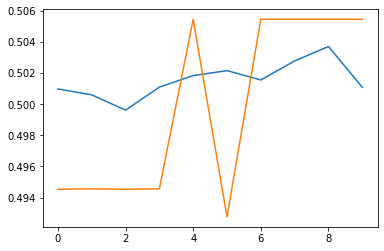

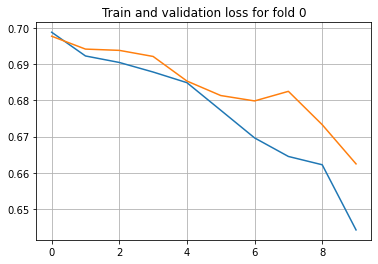

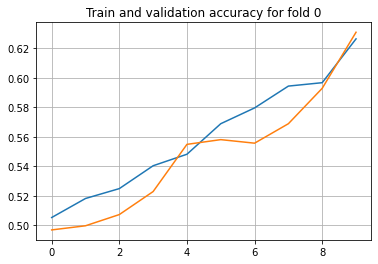

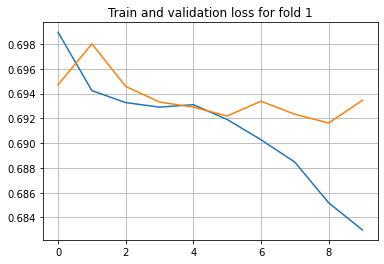

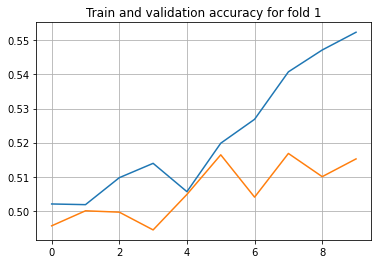

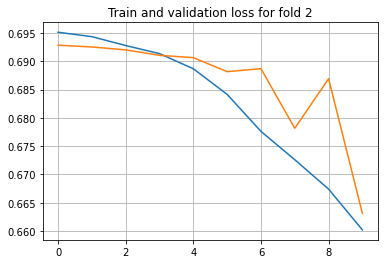

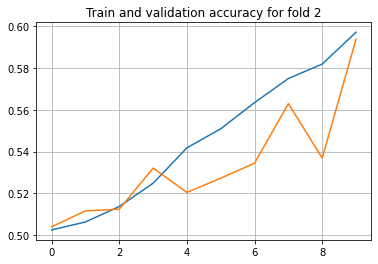

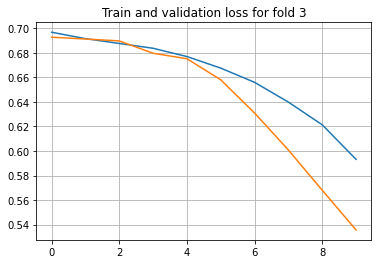

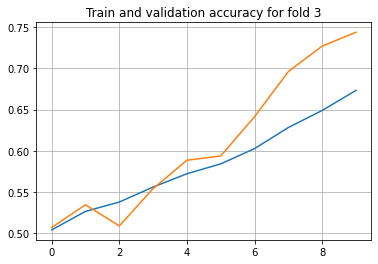

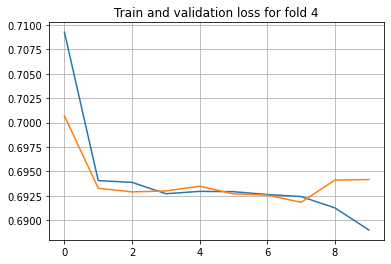

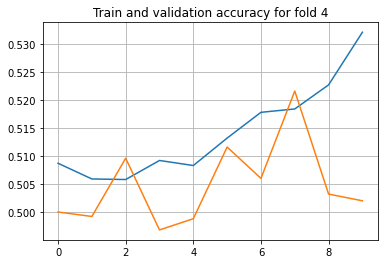

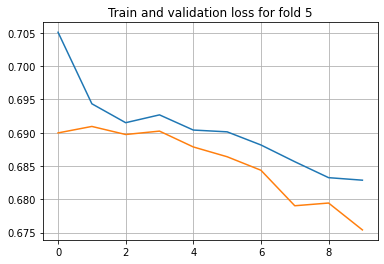

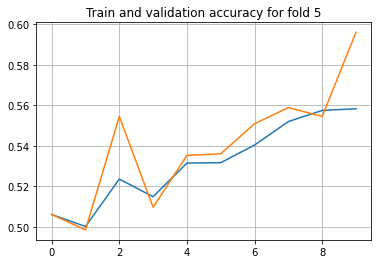

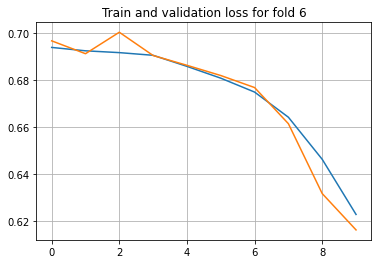

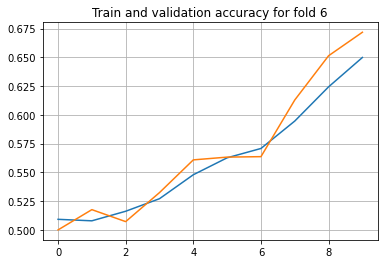

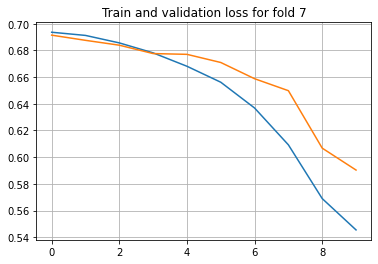

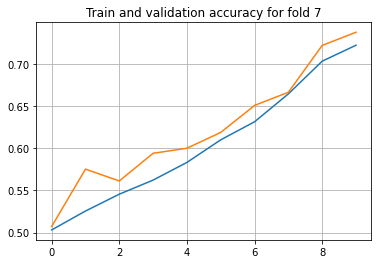

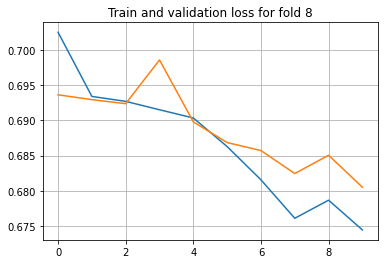

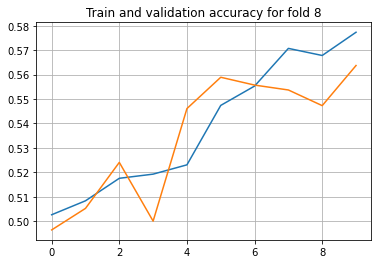

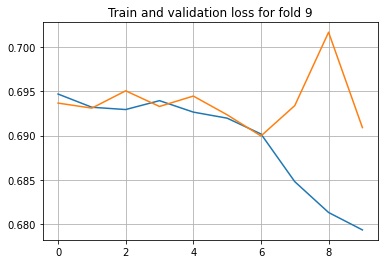

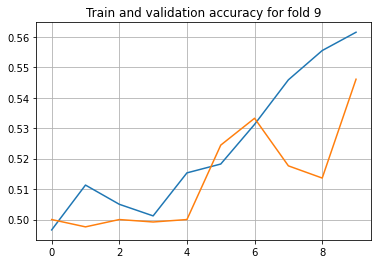

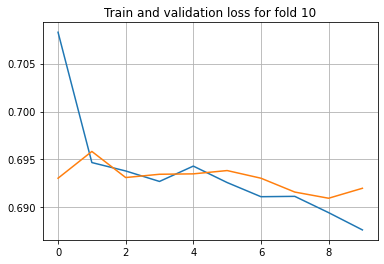

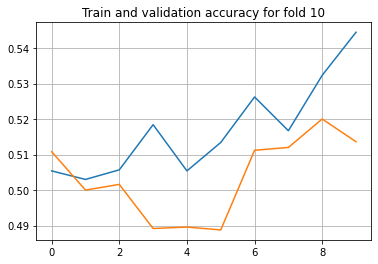

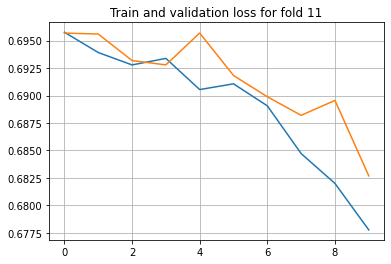

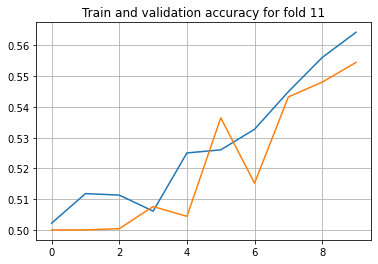

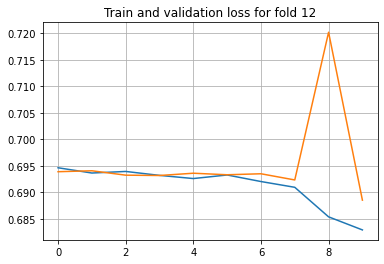

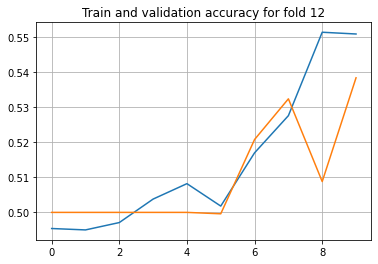

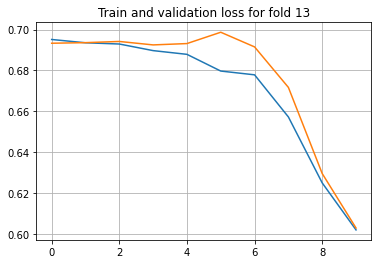

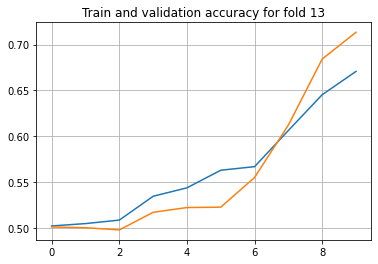

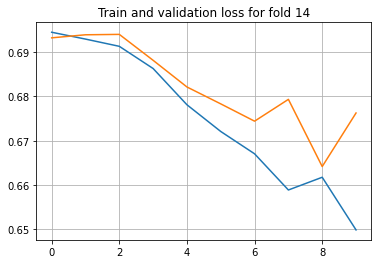

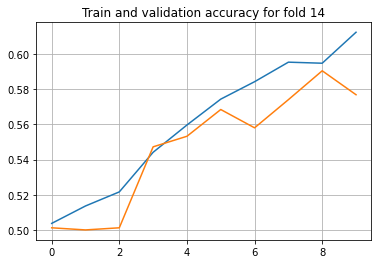

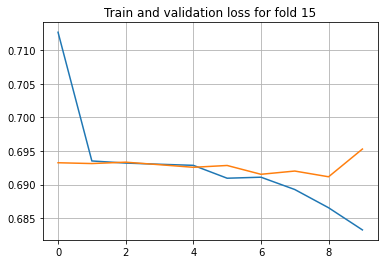

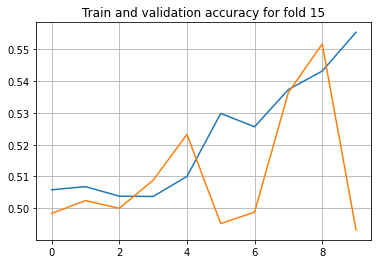

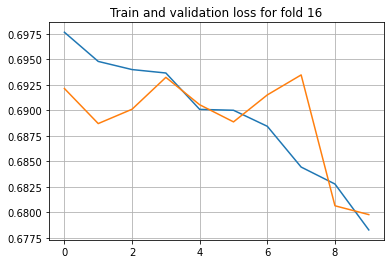

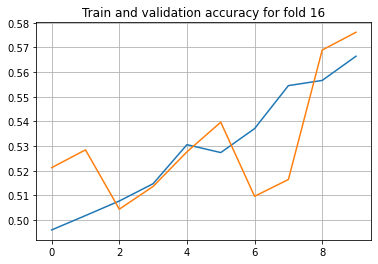

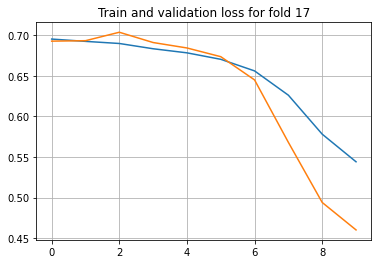

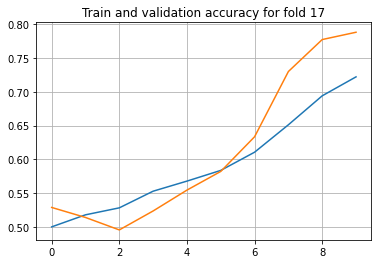

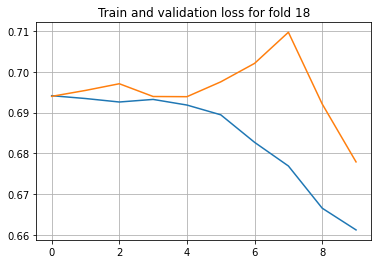

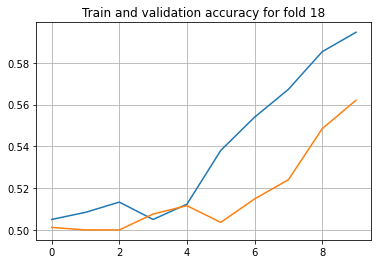

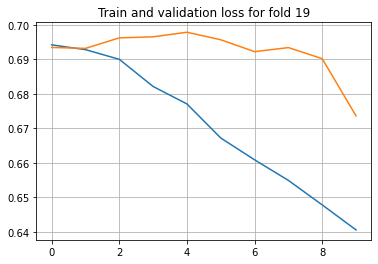

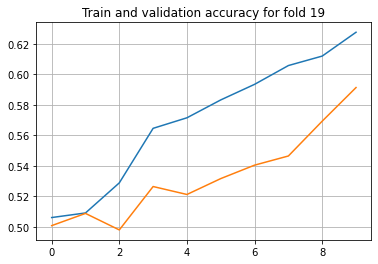

In [20]:
# @title Definición main {form-width:"25%"}

if(pre_train):
  print("pre train")
  wrapper_pre_train(root_dir, save_dir, datatype, t_start, t_end, fs, float_point, Classes, Conditions,
                  batch_size_pre, val_len, window_len, window_step, scl, SEED, eu_aligment, DEVICE, sub, plotting)
  
wrapper_fine_tuning(root_dir, save_dir, datatype, sub, t_start, t_end, fs, float_point, Classes,
                   Conditions, test_len, val_len, window_len, window_step, scl, SEED, eu_aligment, DEVICE, plotting)